
Sensitivity check (IQR thresholds):


,k,outlier_products
0,1.5,35
1,2.0,1
2,3.0,0



Detected outliers (k=1.5): 35 products

Outliers by price band:


,price_band,outlier_products
0,0,10
1,1,5
2,2,5
3,3,3
4,4,12



Top brands among outliers:


brand_name
Anastasia Beverly Hills    4
The Ordinary               4
Drunk Elephant             4
Urban Decay                2
Tatcha                     2
Dior                       2
NARS                       2
Fenty Beauty by Rihanna    2
CHANEL                     1
Viktor&Rolf                1
Name: count, dtype: int64


Top categories among outliers:


secondary_category
Treatments                8
Eye                       6
Lip                       6
Face                      5
Women                     3
Cheek                     2
Moisturizers              2
Cleansers                 1
Lip Balms & Treatments    1
Masks                     1
Name: count, dtype: int64


Top extreme outliers (highest loves):


,product_name,brand_name,secondary_category,price_usd,loves_count,avg_sentiment,reviews
6242,Soft Pinch Liquid Blush,Rare Beauty by Selena Gomez,Cheek,23.0,1401068,NaN,4733.0
5249,Radiant Creamy Concealer,NARS,Face,32.0,1153594,NaN,12887.0
4431,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,Lip Balms & Treatments,24.0,1081315,0.639,16118.0
6434,Cream Lip Stain Liquid Lipstick,SEPHORA COLLECTION,Lip,15.0,1029051,NaN,11111.0
2523,Gloss Bomb Universal Lip Luminizer,Fenty Beauty by Rihanna,Lip,21.0,968317,NaN,12136.0
2524,Pro Filt’r Soft Matte Longwear Liquid Foundation,Fenty Beauty by Rihanna,Face,40.0,856497,NaN,16935.0
5250,Blush,NARS,Cheek,32.0,840076,NaN,18127.0
247,Brow Wiz Ultra-Slim Precision Brow Pencil,Anastasia Beverly Hills,Eye,25.0,834189,NaN,15885.0
4458,Translucent Loose Setting Powder,Laura Mercier,Face,43.0,813497,NaN,9335.0
7648,Niacinamide 10% + Zinc 1% Oil Control Serum,The Ordinary,Treatments,6.0,763168,0.499,5778.0


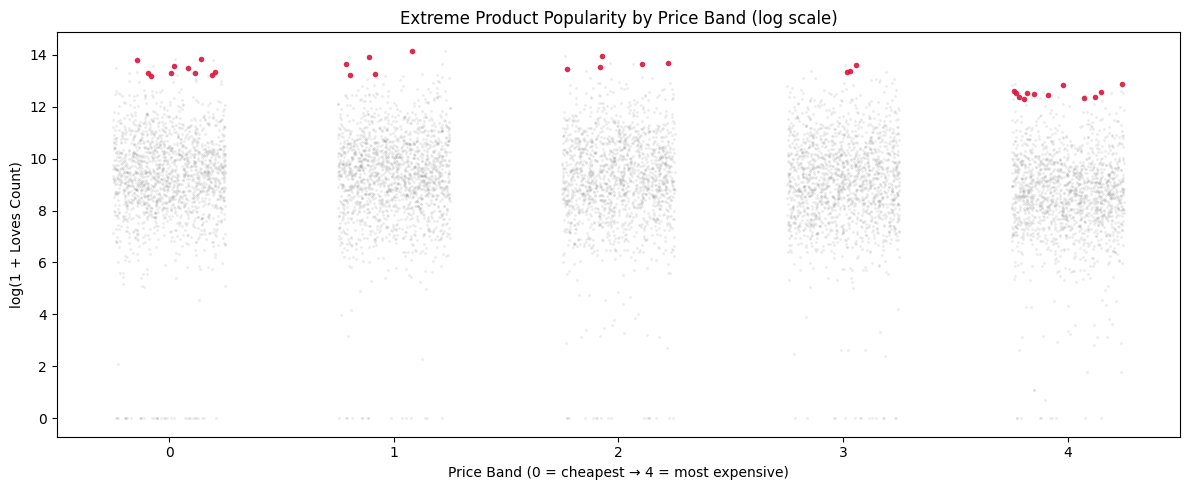

In [9]:
# =========================
# Outlier & Robustness Analysis (Single Cell)
# =========================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Safety & prep ----------
required = ["product_id", "loves_count", "price_usd", "price_band"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

df = df.copy()
df["loves_count"] = pd.to_numeric(df["loves_count"], errors="coerce")
df["price_usd"] = pd.to_numeric(df["price_usd"], errors="coerce")
df = df.dropna(subset=["loves_count", "price_band"])

# Log transform (defense: heavy skew)
df["log_loves"] = np.log1p(df["loves_count"])

# ---------- Helper: IQR outliers per price band ----------
def iqr_outliers(data, k=1.5):
    outs = []
    for b, g in data.groupby("price_band"):
        q1, q3 = g["log_loves"].quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + k * iqr
        o = g[g["log_loves"] > upper].copy()
        o["k"] = k
        o["iqr_upper"] = upper
        outs.append(o)
    return pd.concat(outs) if outs else pd.DataFrame()

# ---------- Sensitivity checks (k = 1.5 → 3.0) ----------
ks = [1.5, 2.0, 3.0]
outlier_sets = {k: iqr_outliers(df, k=k) for k in ks}

sensitivity_table = pd.DataFrame({
    "k": ks,
    "outlier_products": [outlier_sets[k]["product_id"].nunique() for k in ks]
})

print("\nSensitivity check (IQR thresholds):")
display(sensitivity_table)

# Use baseline k=1.5 for analysis
outliers = outlier_sets[1.5].copy()
print(f"\nDetected outliers (k=1.5): {outliers['product_id'].nunique()} products")


# ---------- Where do outliers occur? ----------
print("\nOutliers by price band:")
display(outliers.groupby("price_band")["product_id"].nunique().reset_index(name="outlier_products"))

if "brand_name" in df.columns:
    print("\nTop brands among outliers:")
    display(outliers["brand_name"].value_counts().head(10))

if "secondary_category" in df.columns:
    print("\nTop categories among outliers:")
    display(outliers["secondary_category"].value_counts().head(10))

# ---------- Inspect the most extreme products ----------
cols = ["product_name", "brand_name", "secondary_category", "price_usd",
        "loves_count", "avg_sentiment", "reviews"]
cols = [c for c in cols if c in outliers.columns]

print("\nTop extreme outliers (highest loves):")
display(outliers.sort_values("loves_count", ascending=False)[cols].head(15))

# ---------- Visualization: distribution + highlighted outliers ----------
plt.figure(figsize=(12,5))
sns.stripplot(data=df, x="price_band", y="log_loves",
              jitter=0.25, alpha=0.15, size=2, color="grey")
sns.stripplot(data=outliers, x="price_band", y="log_loves",
              jitter=0.25, alpha=0.9, size=4, color="crimson")
plt.title("Extreme Product Popularity by Price Band (log scale)")
plt.xlabel("Price Band (0 = cheapest → 4 = most expensive)")
plt.ylabel("log(1 + Loves Count)")
plt.tight_layout()
plt.show()
